In [1]:
import numpy as np 
import pandas as pd 
import random
import matplotlib.pyplot as plt 
import os
pd.set_option('display.max_rows', 200)
%matplotlib inline

In [2]:
# define folder where data resides 
DATAFOLDER = "/Users/snuffles753/Documents/NYU-GSAS/ds1003/term-project/data"

In [ ]:
import csv
import os
first = True
with open(os.path.join(DATAFOLDER,'final_subset.csv'), 'w') as f_write:
    with open(os.path.join(DATAFOLDER,'decision_sched_merge_adjdate.csv'), "r") as f:
        read = csv.DictReader(f, delimiter=',')
        for row in read:
            if first:
                f_write.write("case_id,proceeding_id,year,judge_id,nationality,lawyer,city_id\n")
                first = False
            else:
                f_write.write("{},{},{},{},{},{},{}\n".format(row['idncase'], row['idnproceeding'],
                                                              row['input_year'], row['judgeid'],
                                                              row['nat'],row['lawyer'],row['cityid']))

In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
# conf = SparkConf().setAppName("App")
# conf = conf.setMaster('local[*]').set('spark.executor.memory', '5G')\
# .set('spark.driver.memory', '5G')\
# .set('spark.driver.maxResultSize', '5G')

sc = SparkContext.getOrCreate()
sqlContext=SQLContext(sc);


In [4]:
spark=sqlContext.sparkSession
master_dchen = spark.read.csv(os.path.join(DATAFOLDER,'decision_sched_merge_adjdate.csv'),
                header=True,mode="DROPMALFORMED")
master_dchen.printSchema()
master_dchen.show(3)

root
 |-- _c0: string (nullable = true)
 |-- idncase: string (nullable = true)
 |-- nat: string (nullable = true)
 |-- case_type: string (nullable = true)
 |-- c_asy_type: string (nullable = true)
 |-- idnproceeding: string (nullable = true)
 |-- base_city_code: string (nullable = true)
 |-- hearing_loc_code: string (nullable = true)
 |-- dec_type: string (nullable = true)
 |-- dec_code: string (nullable = true)
 |-- other_comp: string (nullable = true)
 |-- attorney_flag: string (nullable = true)
 |-- ij_code: string (nullable = true)
 |-- tracid: string (nullable = true)
 |-- comp_year: string (nullable = true)
 |-- comp_month: string (nullable = true)
 |-- comp_day: string (nullable = true)
 |-- comp_date: string (nullable = true)
 |-- osc_year: string (nullable = true)
 |-- osc_month: string (nullable = true)
 |-- osc_day: string (nullable = true)
 |-- osc_date: string (nullable = true)
 |-- input_year: string (nullable = true)
 |-- input_month: string (nullable = true)
 |-- input_

In [18]:
spark=sqlContext.sparkSession

tblAppeal = spark.read.csv(os.path.join(DATAFOLDER, 'raw/tblAppeal.csv'),
                header=True,mode="DROPMALFORMED")
tblAppeal = tblAppeal.dropDuplicates(['idncase'])

tblAppeal.printSchema()
tblAppeal.show(3)
print(tblAppeal.count())

root
 |-- idnAppeal: string (nullable = true)
 |-- idncase: string (nullable = true)
 |-- idnProceeding: string (nullable = true)
 |-- strAppealCategory: string (nullable = true)
 |-- strAppealType: string (nullable = true)
 |-- datAppealFiled: string (nullable = true)
 |-- strFiledBy: string (nullable = true)
 |-- datAttorneyE27: string (nullable = true)
 |-- datBIADecision: string (nullable = true)
 |-- strBIADecision: string (nullable = true)
 |-- strBIADecisionType: string (nullable = true)
 |-- strCaseType: string (nullable = true)
 |-- strLang: string (nullable = true)
 |-- strNat: string (nullable = true)
 |-- strProceedingIHP: string (nullable = true)
 |-- strCustody: string (nullable = true)
 |-- strProbono: string (nullable = true)

+---------+-------+-------------+-----------------+-------------+-------------------+----------+--------------+-------------------+--------------+------------------+-----------+-------+------+----------------+----------+----------+
|idnAppeal|idnc

In [56]:
spark=sqlContext.sparkSession
#case_id,proceeding_id,year,judge_id,nationality,lawyer,city_id
nationals = spark.read.csv(os.path.join(DATAFOLDER,'final_subset.csv'),
                header=True,mode="DROPMALFORMED")
print(nationals.count())
nationals = nationals.dropDuplicates(['case_id', 'year'])
nationals.printSchema()
nationals.show(10)
print(nationals.count())
#5664752
#4508147 - without year drop
#4976392 - with year drop

5664752
root
 |-- case_id: string (nullable = true)
 |-- proceeding_id: string (nullable = true)
 |-- year: string (nullable = true)
 |-- judge_id: string (nullable = true)
 |-- nationality: string (nullable = true)
 |-- lawyer: string (nullable = true)
 |-- city_id: string (nullable = true)

+-------+-------------+------+--------+-----------+------+-------+
|case_id|proceeding_id|  year|judge_id|nationality|lawyer|city_id|
+-------+-------------+------+--------+-----------+------+-------+
|2046985|      3200124|2004.0|     325|         MO|     1|      9|
|2047073|      3200025|2003.0|     325|         KU|     0|     25|
|2047074|      3200026|2003.0|     402|         MX|     0|     15|
|2047255|            8|1987.0|     335|         CA|     1|     28|
|2047428|        91604|1998.0|     134|         MX|     1|     49|
|2047465|      3199807|2003.0|     194|         HO|     0|     25|
|2047615|      3199354|2003.0|     115|         BR|     1|     20|
|2048200|        92804|2001.0|      

In [24]:
nationals.createOrReplaceTempView("NATIONALS")
tblAppeal.createOrReplaceTempView("APPEALS")
appeal_caseids = spark.sql("SELECT DISTINCT idncase as caseId FROM APPEALS")
appeal_caseids.createOrReplaceTempView("APPEAL_CASE_IDS")

appeals_sql = """
SELECT B.case_id, B.nationality
FROM
(
SELECT M.case_id, A.caseId, M.nationality
FROM NATIONALS M
JOIN APPEAL_CASE_IDS A
ON M.case_id = A.caseId
) B
"""
appeals = spark.sql(appeals_sql)
# appeals.show()
# num_appeals = appeals.count()
# print(num_appeals)

non_appeals_sql = """
SELECT B.case_id, B.nationality
FROM
(
SELECT M.case_id, A.caseId, M.nationality
FROM NATIONALS M
LEFT JOIN APPEAL_CASE_IDS A
ON M.case_id = A.caseId
) B
WHERE caseId IS NULL
"""
non_appeals = spark.sql(non_appeals_sql)
# non_appeals.show()
# num_non_appeals = non_appeals.count()
# print(num_non_appeals)
        
appeals.createOrReplaceTempView("APPEALS_POP")
non_appeals.createOrReplaceTempView("NON_APPEALS_POP")

In [25]:
num_appeals = appeals.count()
num_non_appeals = non_appeals.count()

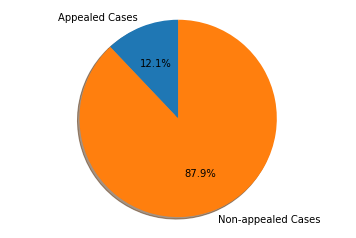

In [26]:


labels = 'Appealed Cases', 'Non-appealed Cases'
sizes = [num_appeals, num_non_appeals]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [27]:
print(num_appeals)
print(num_non_appeals)

544855
3963292


In [28]:
appeals_sql = """
SELECT *
FROM
(
SELECT nationality, ROUND(COUNT(case_id) *100 / 544855, 2) as percentage, COUNT(case_id) as count
FROM APPEALS_POP
GROUP BY nationality
) B
ORDER BY B.count desc
LIMIT 10
"""
appeals_nat = spark.sql(appeals_sql)
appeals_nat.show()

non_appeals_sql = """
SELECT *
FROM
(
SELECT nationality, ROUND(COUNT(case_id) *100 / 3963292, 2) as percentage, COUNT(case_id) as count
FROM NON_APPEALS_POP
GROUP BY nationality
) B
ORDER BY B.count desc
LIMIT 10
"""
non_appeals_nat = spark.sql(non_appeals_sql)
non_appeals_nat.show()

+-----------+----------+------+
|nationality|percentage| count|
+-----------+----------+------+
|         MX|     21.93|119488|
|         CH|      9.07| 49434|
|         ES|      8.02| 43688|
|         HA|      6.82| 37154|
|         GT|      5.65| 30758|
|         CO|      3.82| 20833|
|         NU|       3.5| 19075|
|         IN|      2.51| 13682|
|         HO|      2.33| 12676|
|         DR|      2.11| 11486|
+-----------+----------+------+

+-----------+----------+-------+
|nationality|percentage|  count|
+-----------+----------+-------+
|         MX|     41.38|1639911|
|         ES|      9.78| 387775|
|         GT|      7.43| 294294|
|         HO|      6.83| 270866|
|         CH|      2.55| 100869|
|         CU|      2.15|  85284|
|         DR|      1.97|  78027|
|         CO|      1.88|  74444|
|         NU|      1.87|  74093|
|         BR|      1.85|  73282|
+-----------+----------+-------+



In [41]:
nationals.createOrReplaceTempView("NATIONALS")
tblAppeal.createOrReplaceTempView("APPEALS")
appeal_caseids = spark.sql("SELECT DISTINCT idncase as caseId FROM APPEALS")
appeal_caseids.createOrReplaceTempView("APPEAL_CASE_IDS")

appeal_proportion_by_year_sql = """
SELECT year, COUNT(caseId) / COUNT(case_id) * 100 as appeal_rate
FROM
(
SELECT M.case_id, A.caseId, M.nationality, M.year
FROM NATIONALS M
LEFT JOIN APPEAL_CASE_IDS A
ON M.case_id = A.caseId
) B
GROUP BY year
ORDER BY year
"""
    
appeal_proportion_by_year = spark.sql(appeal_proportion_by_year_sql)
df_pd_appeals_by_year = appeal_proportion_by_year.toPandas()


In [51]:
df_pd_appeals_by_year.dropna(inplace=True)
df_pd_appeals_by_year.year = df_pd_appeals_by_year.year.astype(float)
df_pd_appeals_by_year.year = df_pd_appeals_by_year.year.astype(int)
df_pd_appeals_by_year = df_pd_appeals_by_year.query('year>1975')
df_pd_appeals_by_year.head()


,year,appeal_rate
22,1976,26.865672
23,1977,25.454545
24,1978,28.112450
25,1979,26.033058
26,1980,27.036199


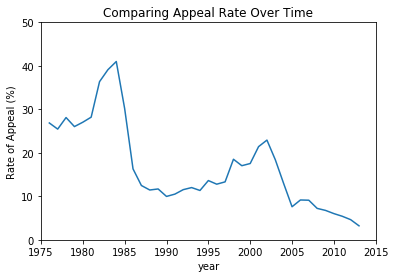

In [60]:
    
plt.figure()
df_pd_appeals_by_year.plot(x='year', legend=None)
plt.title('Comparing Appeal Rate Over Time')
plt.xlim(1975,2015)
plt.ylim(0, 50)
plt.ylabel('Rate of Appeal (%)')